In [3]:
# Goal: Fix that annoying tick in the graph caused by bad mathematical formulation of the model function
import sys, os
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

import george
from george import kernels
import george.modeling as gmodel
from george.utils import multivariate_gaussian_samples

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


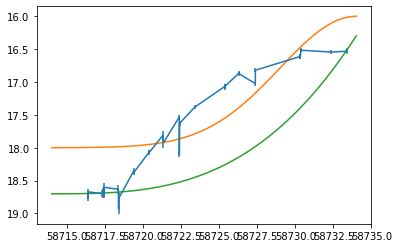

In [159]:
ds = dataset.load_dataset('SN2019odp_phot')
ztflc = ds.get_sub_dataset("ZTF")
scalezp = 0
band = 'r'
ztflc.sort('mjd')
idx = np.logical_and(ztflc['mjd'] < 58734, ztflc['mjd'] > 58714)
idx = np.logical_and(idx, ~ztflc['upper_limit'])
plt.errorbar(ztflc['mjd'][idx], ztflc['mag'][idx], yerr=ztflc['mag_err'][idx])
plt.gca().invert_yaxis()
t_grid = np.linspace(-20,0) #+ ds.transient.prior_t0
plt.plot(t_grid+ds.transient.prior_t0, 18-2*np.exp(-(t_grid)**2/2/5**2))
plt.plot(t_grid+ds.transient.prior_t0, 18.7 + -3e-4*(t_grid+20)**3)
#ztflc

In [4]:
class ModifiedContardo(gmodel.Model):
    parameter_names = ('linear_intercept', 'linear_slope', 'gaussian_amplitude', 'gaussian_t0','gaussian_sigma', 'rise_t0', 'rise_timescale', 'plateau_level')

    def get_value(self, x):
        phase = x
        
        ret = (self.linear_intercept + self.linear_slope / 1e3 * phase + self.gaussian_amplitude * np.exp(-(phase+self.gaussian_t0)**2 / 2 / self.gaussian_sigma**2))/(1-np.exp((self.rise_t0-x)/self.rise_timescale))
        idx = np.logical_and(phase < -5, ret > self.plateau_level)
        ret[idx] = self.plateau_level
        #ret[~idx] = 0
        return ret

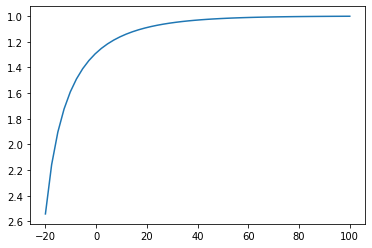

In [7]:
t = np.linspace(-20, 100)
rise_t0 = -30
rise_timescale = 20
y = 1/(1-np.exp((rise_t0-np.arctan(t)/rise_timescale))
plt.plot(t,y)
plt.gca().invert_yaxis()

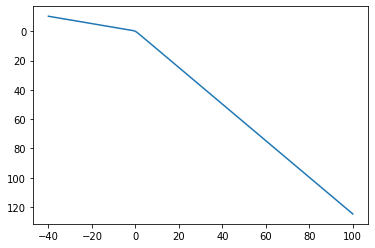

In [43]:
t = np.linspace(-40, 100, 1000)
y = np.arctan(t/4)
#plt.plot(t, -y/np.pi+0.5)
tnew = t * (1+np.arctan(t)/np.pi-0.25)
y = 1/(1-np.exp((rise_t0-tnew)/rise_timescale))
idx = t > -rise_timescale
#plt.plot(t[idx], y[idx])
plt.plot(t, tnew)
plt.gca().invert_yaxis()

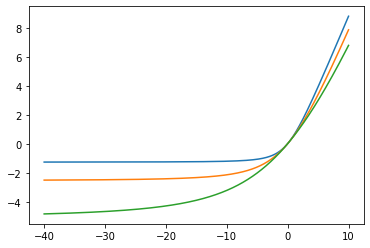

In [54]:
t = np.linspace(-40, 10, 1000)
y = -np.arctan(t/4)/np.pi+0.5
plt.plot(t,(1-y)*t)
y = -np.arctan(t/8)/np.pi+0.5
plt.plot(t,(1-y)*t)
y = -np.arctan(t/16)/np.pi+0.5
plt.plot(t,(1-y)*t)

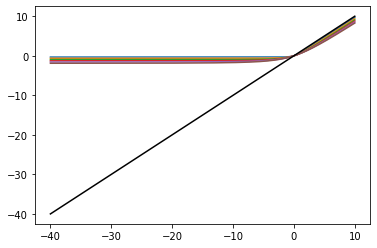

In [64]:
t = np.linspace(-40, 10, 1000)
for tau in [1,2,3,4,5,6]:
    tnew = t * (1+np.arctan(t/tau)/np.pi-0.5)
    plt.plot(t, tnew, label=tau)
plt.plot(t,t, color='black')

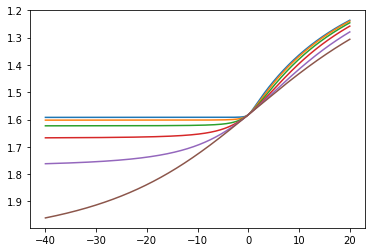

In [65]:
t = np.linspace(-40, 20, 1000)
for tau in [1,2,4,8,16,32]:
    tnew = t * (1+np.arctan(t/tau)/np.pi-0.5)
    y = 1/(1-np.exp((rise_t0-tnew)/rise_timescale))
    plt.plot(t, y, label=tau)
plt.gca().invert_yaxis()

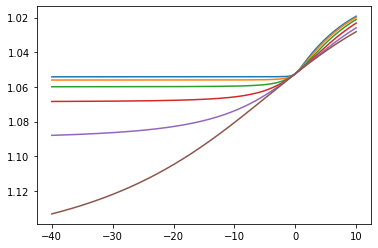

In [60]:
t = np.linspace(-40, 10, 1000)
rise_timescale = 10
for tau in [1,2,4,8,16,32]:
    tnew = t * (1+np.arctan(t/tau)/np.pi-0.5)
    y = 1/(1-np.exp((rise_t0-tnew)/rise_timescale))
    plt.plot(t, y, label=tau)
plt.gca().invert_yaxis()

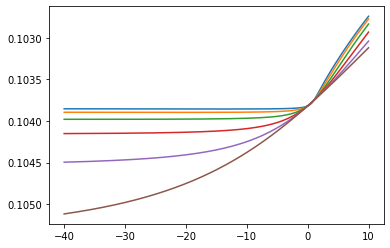

In [67]:
t = np.linspace(-40, 10, 1000)
rise_timescale = 30
for tau in [1,2,4,8,16,32]:
    tnew = t * (1+np.arctan((t-1)/tau)/np.pi-0.5)
    y = 1/(10-16e-6*t-np.exp((rise_t0-tnew)/rise_timescale))
    plt.plot(t, y, label=tau)
plt.gca().invert_yaxis()

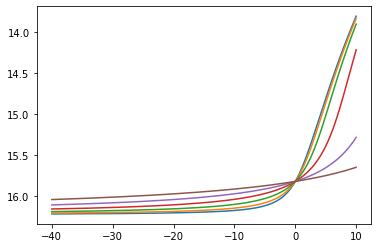

In [74]:
tau = 4
t = np.linspace(-40, 10, 1000)
rise_timescale = 30
for toff in [1,2,4,8,16,32]:
    tnew = t * (1+np.arctan((t-toff)/tau)/np.pi-0.5)
    y = (10+16e-6*t)/(1-np.exp((rise_t0-tnew)/rise_timescale))
    plt.plot(t, y, label=tau)
plt.gca().invert_yaxis()

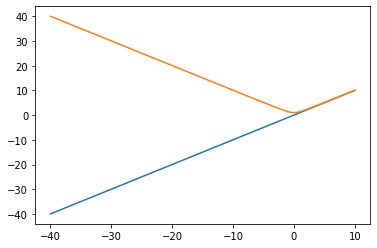

In [76]:
t = np.linspace(-40, 10, 1000)
plt.plot(t,t)
plt.plot(t, np.sqrt(1**2 + t**2))

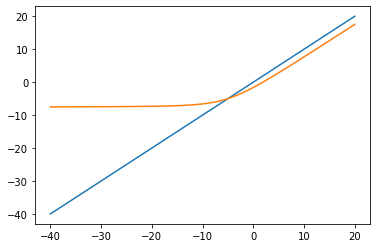

In [85]:
t = np.linspace(-40, 20, 1000)
t0 = -5
tnew = t0 + (t-t0)*(1+np.arctan((t-t0)/8)/np.pi-0.5)
plt.plot(t, t)
plt.plot(t,tnew)

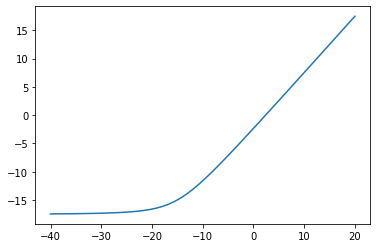

In [86]:
t = np.linspace(-40, 20)
time_sat = -27 - 6*np.log(1-16.6/19.2)
phase_sat = time_sat + (t-time_sat)*(1+np.arctan((t-time_sat)/8)/np.pi-0.5)
plt.plot(t, phase_sat)

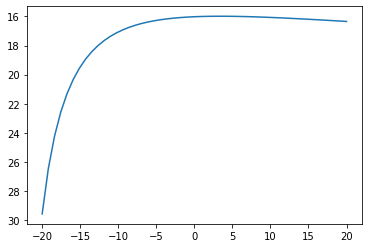

In [164]:
# estimate deviation from m(t) ~ m_0/factor at beginning of LC
g_amp = -0.6
g_t0 = 1.48
g_sigma = 22.3
m0 = 16.4
t0 = -24.3
timescale = 5.7

t = np.linspace(-20, 20)
lc_lin = m0/(1-np.exp((t0-t)/timescale))
#plt.plot(t, lc_lin, label='Lin-only')
lc_all = (m0 + g_amp * np.exp(-(t+g_t0)**2 / 2 / g_sigma**2)) /(1-np.exp((t0-t)/timescale))
#plt.plot(t, lc_all, label='All')
lc_all = (m0+16e-3*t+g_amp * np.exp(-(t+g_t0)**2 / 2 / g_sigma**2)) /(1-np.exp((t0-t)/timescale))
plt.plot(t, lc_all, label='G')
#plt.axhline(m0)
plt.gca().invert_yaxis()

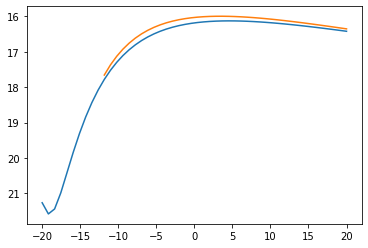

In [198]:
# estimate deviation from m(t) ~ m_0/factor at beginning of LC
g_amp = -0.6
g_t0 = 1.48
g_sigma = 22.3
m0 = 16.4
t0 = -24.3
timescale = 5.7

t = np.linspace(-20, 20)
lc_lin = m0/(1-np.exp((t0-t)/timescale))
#plt.plot(t, lc_lin, label='Lin-only')
lc_all = (m0 + g_amp * np.exp(-(t+g_t0)**2 / 2 / g_sigma**2)) /(1-np.exp((t0-t)/timescale))
#plt.plot(t, lc_all, label='All')
lc_old = (m0+16e-3*t+g_amp * np.exp(-(t+g_t0)**2 / 2 / g_sigma**2)) /(1-np.exp((t0-t)/timescale))
lc_plateau = 18.5

smooth_tau = 2
smooth_t0 = -20
smooth_f = np.arctan((t-smooth_t0)/smooth_tau)/np.pi + 0.5

plt.plot(t, lc_plateau + (lc_old-lc_plateau)*smooth_f**2, label='G')
plt.plot(t[10:], lc_old[10:])
#plt.axhline(m0)
plt.gca().invert_yaxis()

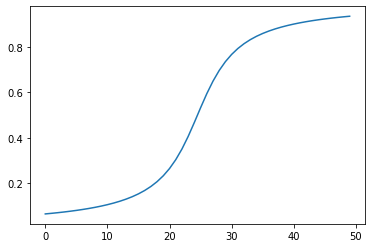

In [167]:
plt.plot(np.arctan(np.linspace(-5,5))/np.pi+0.5)

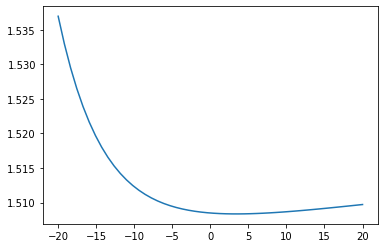

In [189]:
plt.plot(t, np.arctan(lc_old))

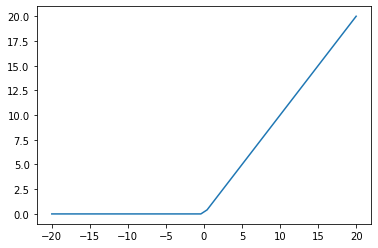

In [190]:
plt.plot(t, t/2*(1+t/np.sqrt(t**2+1e-3**2)))